In [55]:
using DataFrames, RCall, Suppressor, PyPlot, HTTP, LightGraphs, Cairo, Fontconfig, Colors, CSV

In [3]:
include("code/BGSM_effective_resistance.jl");
include("code/model_selection.jl");
R"library('genlasso'); library('Matrix')";
using PyCall
@pyimport GraphSegment
@pyimport numpy

Loading required package: Matrix
Loading required package: igraph

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union



In [4]:
d1 = HTTP.get("http://www.cs.utah.edu/~lifeifei/research/tpq/NA.cnode");
d2 = HTTP.get("http://www.cs.utah.edu/~lifeifei/research/tpq/NA.cedge");
data1 = readdlm(d1.body);
data3 = readdlm(d2.body);
data2 = Array{Int}(data3[:,2:3])
lat = data1[:,2];
lon = data1[:,3];
ind = (lat .> 6000) .& (lat .<= 6800) .& (lon .<= 6600) .& (lon .> 5800);
index = Array{Int}(data1[ind,1]); lat = lat[ind]; lon = lon[ind];
n = sum(ind)
ind1 = findin(data2[:,1], index);
edgeind = ind1[findin(ind1, findin(data2[:,2], index))];
edge = data2[edgeind,:];
index = sort(unique(edge));
n = length(index); p = size(edge,1);

In [5]:
g = SimpleGraph(n); a = zeros(p); loc_edge = zeros(p,4);
for i = 1:p
    a[i] = add_edge!(g, (find(index .== edge[i,1])[1], find(index .== edge[i,2])[1]))
    loc_edge[i,:] = [data1[edge[i,1] + 1,2:3]; data1[edge[i,2] + 1,2:3]]
end
comp = connected_components(g)[1];
index = index[comp]
edge = edge[find(a .== 1),:];
loc_edge = loc_edge[find(a .== 1),:];
edge_comp = findin(edge[:,1], index);
edge = edge[edge_comp,:];
loc_edge = loc_edge[edge_comp,:];
g = g[comp];
D = -incidence_matrix(g, oriented = true)';
p,n = size(D);
R = effective_resistance(g, D);

In [6]:
loc_x = data1[index+1,2];
loc_y = data1[index+1,3];
srand(2019); src = rand(1:n, 4); distance = zeros(n,4); col = zeros(Int, n);
for i = 1:4
    temp = dijkstra_shortest_paths(g, src[i]).dists;
    distance[:,i] = temp;
end
for i = 1:n
    col[i] = findmin(distance[i,:])[2]
end
col = [1;3;4;2][col];

In [7]:
minind = zeros(5); score = 0;
for i = 1:5
    srand(1);
    y = (i+2) * col/3 + rand(n);
    score = zeros(5);
    for j = 1:5
        out = BGSM_effective_resistance(y,D,R, v0 = 1e-3 * 2^j, verbose = false);
        ms = model_selection(out);
        score[j] = ms[:score];
    end
    minind[i] = findmin(score)[2];
end

In [8]:
srand(1);
y = (1+2) * col/3 + rand(n);
out1 = BGSM_effective_resistance(y,D,R, v0 = 1e-3 * 2^minind[1], verbose = false);
ms1 = model_selection(out1);
ind1 = zeros(Int, n)
for i = 1:length(ms1[:c])
    ind1[ms1[:c][i]] = Int(i);
end
srand(1);
y = (2+2) * col/3 + rand(n);
out2 = BGSM_effective_resistance(y,D,R, v0 = 1e-3 * 2^minind[2], verbose = false);
ms2 = model_selection(out2);
ind2 = zeros(Int, n)
for i = 1:length(ms2[:c])
    ind2[ms2[:c][i]] = Int(i);
end
srand(1);
y = (3+2) * col/3 + rand(n);
out3 = BGSM_effective_resistance(y,D,R, v0 = 1e-3 * 2^minind[3], verbose = false);
ms3 = model_selection(out3);
ind3 = zeros(Int, n)
for i = 1:length(ms3[:c])
    ind3[ms3[:c][i]] = Int(i);
end
srand(1);
y = (4+2) * col/3 + rand(n);
out4 = BGSM_effective_resistance(y,D,R, v0 = 1e-3 * 2^minind[4], verbose = false);
ms4 = model_selection(out4);
ind4 = zeros(Int, n)
for i = 1:length(ms4[:c])
    ind4[ms4[:c][i]] = Int(i);
end
srand(1);
y = (5+2) * col/3 + rand(n);
out5 = BGSM_effective_resistance(y,D,R, v0 = 1e-3 * 2^minind[5], verbose = false);
ms5 = model_selection(out5);
ind5 = zeros(Int, n)
for i = 1:length(ms5[:c])
    ind5[ms5[:c][i]] = Int(i);
end

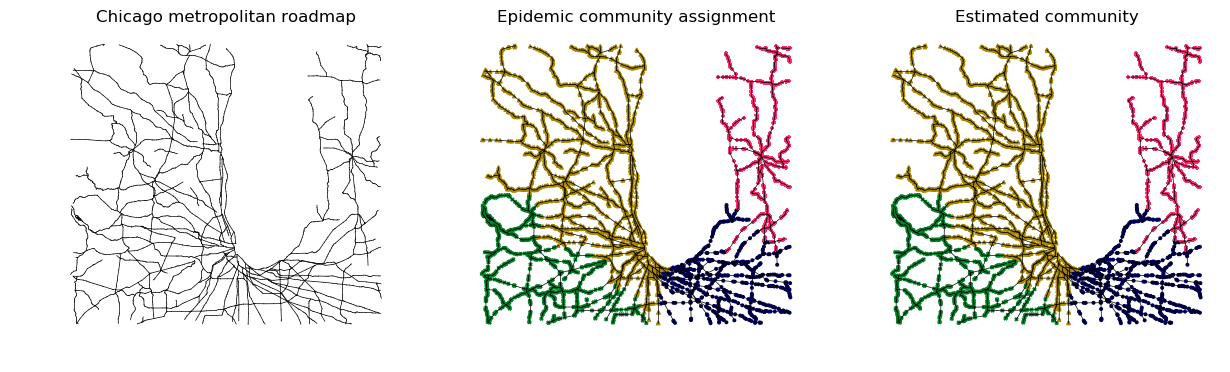

In [9]:
# Generate n maximally distinguishable colors in LCHab space.
cols = distinguishable_colors(200)[[6;10;16;17;1;2;3;4;5;7;8;9;11;12;13;14;15;18:200]];
pcols = map(col -> (red(col), green(col), blue(col)), cols);
fig, ax = subplots(figsize = (15,4))
subplot(131)
title("Chicago metropolitan roadmap")
plot(loc_edge[:,[1;3]]',loc_edge[:,[2;4]]', c = :black, linewidth = .5);
axis("off")
subplot(132)
title("Epidemic community assignment")
plot(loc_edge[:,[1;3]]',loc_edge[:,[2;4]]', c = :black, linewidth = .5);
scatter(loc_x[col .== 1],loc_y[col .== 1], s = 5, c = pcols[col][col .== 1], marker = "x")
scatter(loc_x[col .== 2],loc_y[col .== 2], s = 5, c = pcols[col][col .== 2], marker = "^")
scatter(loc_x[col .== 3],loc_y[col .== 3], s = 3.5, c = pcols[col][col .== 3], marker = "o")
scatter(loc_x[col .== 4],loc_y[col .== 4], s = 8.5, c = pcols[col][col .== 4], marker = "+")
axis("off")
subplot(133)
title("Estimated community")
plot(loc_edge[:,[1;3]]',loc_edge[:,[2;4]]', c = :black, linewidth = .5);
col1 = [1;2;5;3;4][ind3];
scatter(loc_x,loc_y, s = 4, c = pcols[col1], marker = ".");
scatter(loc_x[col1 .== 1],loc_y[col1 .== 1], s = 5, c = pcols[col1][col1 .== 1], marker = "x")
scatter(loc_x[col1 .== 2],loc_y[col1 .== 2], s = 5, c = pcols[col1][col1 .== 2], marker = "^")
scatter(loc_x[col1 .== 3],loc_y[col1 .== 3], s = 3.5, c = pcols[col1][col1 .== 3], marker = "o")
scatter(loc_x[col1 .== 4],loc_y[col1 .== 4], s = 8.5, c = pcols[col1][col1 .== 4], marker = "+")
axis("off")
savefig("figure/F11.pdf")

In [18]:
m,p = size(D)
edges = repeat([(0,0)],m);
for i = 1:m
    temp = find(D[i,:] .!= 0);
    edges[i] = (temp[1]-1, temp[2]-1);
end
tind = find(abs.(D * col) .> 1e-8);

In [10]:
srand(1);
y = 1 * col + rand(length(col));
bgsm = zeros(length(y),20);
for i = 1:20
    res1      = BGSM_effective_resistance(y,D,R, v0 = 1e-3 * 1.4^i, b = size(D,1), verbose = false);
    mss1      = model_selection(res1);
    bgsm[:,i] = mss1[:beta]
    println("score: ", mss1[:score]," and # of comp: ",length(mss1[:c]))
end

score: 28619.657553667865 and # of comp: 2421
score: 27392.458597404548 and # of comp: 2144
score: 26227.595300590896 and # of comp: 1883
score: 24783.85824751473 and # of comp: 1564
score: 22488.544646194634 and # of comp: 1068
score: 20139.95018158813 and # of comp: 574
score: 18383.821164926594 and # of comp: 159
score: 18054.687608882912 and # of comp: 9
score: 18020.038080619102 and # of comp: 2
score: 18016.612428109383 and # of comp: 2
score: 18611.35068778961 and # of comp: 1
score: 18611.35068778961 and # of comp: 1
score: 18611.35068778961 and # of comp: 1
score: 18611.35068778961 and # of comp: 1
score: 18611.35068778961 and # of comp: 1
score: 18611.35068778961 and # of comp: 1
score: 18611.35068778961 and # of comp: 1
score: 18611.35068778961 and # of comp: 1
score: 18611.35068778961 and # of comp: 1
score: 18611.35068778961 and # of comp: 1


In [35]:
srand(1);
y         = 1 * col +  rand(length(col));
res1      = BGSM_effective_resistance(y,D,R, v0 = 1e-3 * 1.4^9, b = size(D,1), verbose = false);
mss1      = model_selection(res1);
println("score: ", mss1[:score]," and # of comp: ",length(mss1[:c]))
nzind     = find(abs.(D * mss1[:beta]) .> 1e-8);
tp        = length(findin(tind, nzind));
println("mse: ", norm(y - mss1[:beta])^2/p," fdr: ", 1 - tp/length(nzind)," power : ", tp/length(tind))

score: 18020.038080619102 and # of comp: 2
mse: 0.45633395913650265 fdr: 0.0 power : 0.1935483870967742


In [25]:
srand(1)
y = 1 * col +  rand(length(col));
B     = 5;
err   = zeros(20, B);
out_l0pen = 0;
srand(1);
for b = 1:B
    println(b);
    for i = 1:20
        out_l0pen = GraphSegment.GraphSegment(y,edges, 1.5^(8-i), delta = 1, weights = R, verbose = false);
        sigma     = 1;
        alpha     = 0.2;
        z         = alpha * sigma * randn(p);
        y1        = y + z;
        y2        = y - z/alpha^2;
        mu1       = GraphSegment.GraphSegment(y1,edges, 1.5^(8-i), delta = 1, weights = R, verbose = false);
        err[i,b]  = norm(y2 - mu1)^2/p;
    end
end
l0pen = GraphSegment.GraphSegment(y,edges, 1.5^(8-findmin(sum(err,2))[2]), delta = 1, weights = R, verbose = false)
nzind = find(abs.(D * l0pen) .> 1e-8);
tp    = length(findin(tind, nzind));
println("mse: ", norm(y-l0pen)^2/p," fdr: ", 1 - tp/length(nzind)," power : ", tp/length(tind))

1
2
3
4
5
mse: 0.15142814215310343 fdr: 0.8148148148148149 power : 0.16129032258064516


In [32]:
srand(1);
y = 1.5 * col + rand(length(col));
bgsm = zeros(length(y),20);
for i = 1:20
    res1      = BGSM_effective_resistance(y,D,R, v0 = 1e-3 * 1.4^i, b = size(D,1), verbose = false);
    mss1      = model_selection(res1);
    bgsm[:,i] = mss1[:beta]
    println("score: ", mss1[:score]," and # of comp: ",length(mss1[:c]))
end

score: 26337.14776950713 and # of comp: 1905
score: 25016.36142695963 and # of comp: 1612
score: 23379.56509693966 and # of comp: 1254
score: 21525.020616666665 and # of comp: 860
score: 19654.41289258274 and # of comp: 468
score: 18278.889820994696 and # of comp: 181
score: 17638.217473934346 and # of comp: 45
score: 17458.823089415266 and # of comp: 6
score: 17446.600445467924 and # of comp: 4
score: 17951.802927996378 and # of comp: 3
score: 18571.72751936697 and # of comp: 2
score: 19506.109668336416 and # of comp: 1
score: 19506.109668336416 and # of comp: 1
score: 19506.109668336416 and # of comp: 1
score: 19506.109668336416 and # of comp: 1
score: 19506.109668336416 and # of comp: 1
score: 19506.109668336416 and # of comp: 1
score: 19506.109668336416 and # of comp: 1
score: 19506.109668336416 and # of comp: 1
score: 19506.109668336416 and # of comp: 1


In [34]:
srand(1);
y         = 1.5 * col +  rand(length(col));
res1      = BGSM_effective_resistance(y,D,R, v0 = 1e-3 * 1.4^9, b = size(D,1), verbose = false);
mss1      = model_selection(res1);
println("score: ", mss1[:score]," and # of comp: ",length(mss1[:c]))
nzind     = find(abs.(D * mss1[:beta]) .> 1e-8);
tp        = length(findin(tind, nzind));
println("mse: ", norm(y - mss1[:beta])^2/p," fdr: ", 1 - tp/length(nzind)," power : ", tp/length(tind))

score: 17446.600445467924 and # of comp: 4
mse: 0.08386652184401697 fdr: 0.032258064516129004 power : 0.967741935483871


In [26]:
srand(1)
y = 1.5 * col +  rand(length(col));
B     = 5;
err   = zeros(20, B);
out_l0pen = 0;
srand(1);
for b = 1:B
    println(b);
    for i = 1:20
        out_l0pen = GraphSegment.GraphSegment(y,edges, 1.5^(8-i), delta = 1, weights = R, verbose = false);
        sigma     = 1;
        alpha     = 0.2;
        z         = alpha * sigma * randn(p);
        y1        = y + z;
        y2        = y - z/alpha^2;
        mu1       = GraphSegment.GraphSegment(y1,edges, 1.5^(8-i), delta = 1, weights = R, verbose = false);
        err[i,b]  = norm(y2 - mu1)^2/p;
    end
end
l0pen = GraphSegment.GraphSegment(y,edges, 1.5^(8-findmin(sum(err,2))[2]), delta = 1, weights = R, verbose = false)
nzind = find(abs.(D * l0pen) .> 1e-8);
tp    = length(findin(tind, nzind));
println("mse: ", norm(y-l0pen)^2/p," fdr: ", 1 - tp/length(nzind)," power : ", tp/length(tind))

1
2
3
4
5
mse: 0.09400821105870759 fdr: 0.21875 power : 0.8064516129032258


In [11]:
srand(1);
y = 2 * col + rand(length(col));
bgsm = zeros(length(y),20);
for i = 1:20
    res1      = BGSM_effective_resistance(y,D,R, v0 = 1e-3 * 1.4^i, b = size(D,1), verbose = false);
    mss1      = model_selection(res1);
    bgsm[:,i] = mss1[:beta]
    println("score: ", mss1[:score]," and # of comp: ",length(mss1[:c]))
end

score: 24244.42343356125 and # of comp: 1439
score: 22426.953992820065 and # of comp: 1048
score: 20616.83615145538 and # of comp: 667
score: 19027.79916720337 and # of comp: 336
score: 18107.6976320813 and # of comp: 145
score: 17598.0283863088 and # of comp: 36
score: 17446.251183811266 and # of comp: 4
score: 17446.251183811266 and # of comp: 4
score: 17446.251183811266 and # of comp: 4
score: 18280.37241013131 and # of comp: 3
score: 18280.37241013131 and # of comp: 3
score: 20331.428781958897 and # of comp: 1
score: 20331.428781958897 and # of comp: 1
score: 20331.428781958897 and # of comp: 1
score: 20331.428781958897 and # of comp: 1
score: 20331.428781958897 and # of comp: 1
score: 20331.428781958897 and # of comp: 1
score: 20331.428781958897 and # of comp: 1
score: 20331.428781958897 and # of comp: 1
score: 20331.428781958897 and # of comp: 1


In [31]:
srand(1);
y         = 2 * col +  rand(length(col));
res1      = BGSM_effective_resistance(y,D,R, v0 = 1e-3 * 1.4^8, b = size(D,1), verbose = false);
mss1      = model_selection(res1);
println("score: ", mss1[:score]," and # of comp: ",length(mss1[:c]))
nzind     = find(abs.(D * mss1[:beta]) .> 1e-8);
tp        = length(findin(tind, nzind));
println("mse: ", norm(y - mss1[:beta])^2/p," fdr: ", 1 - tp/length(nzind)," power : ", tp/length(tind))

score: 17446.251183811266 and # of comp: 4
mse: 0.08367576674959801 fdr: 0.0 power : 1.0


In [24]:
srand(1)
y = 2 * col +  rand(length(col));
B     = 5;
err   = zeros(20, B);
out_l0pen = 0;
srand(1);
for b = 1:B
    println(b);
    for i = 1:20
        out_l0pen = GraphSegment.GraphSegment(y,edges, 1.5^(8-i), delta = 1, weights = R, verbose = false);
        sigma     = 1;
        alpha     = 0.2;
        z         = alpha * sigma * randn(p);
        y1        = y + z;
        y2        = y - z/alpha^2;
        mu1       = GraphSegment.GraphSegment(y1,edges, 1.5^(8-i), delta = 1, weights = R, verbose = false);
        err[i,b]  = norm(y2 - mu1)^2/p;
    end
end
l0pen = GraphSegment.GraphSegment(y,edges, 1.5^(8-findmin(sum(err,2))[2]), delta = 1, weights = R, verbose = false)
nzind = find(abs.(D * l0pen) .> 1e-8);
tp    = length(findin(tind, nzind));
println("mse: ", norm(y-l0pen)^2/p," fdr: ", 1 - tp/length(nzind)," power : ", tp/length(tind))

1
2
3
4
5
mse: 0.08367576674956995 fdr: 0.0 power : 1.0


In [29]:
srand(1);
y = 2.5 * col + rand(length(col));
bgsm = zeros(length(y),20);
for i = 1:20
    res1      = BGSM_effective_resistance(y,D,R, v0 = 1e-3 * 1.4^i, b = size(D,1), verbose = false);
    mss1      = model_selection(res1);
    bgsm[:,i] = mss1[:beta]
    println("score: ", mss1[:score]," and # of comp: ",length(mss1[:c]))
end

score: 22011.150521723433 and # of comp: 958
score: 20384.167578833367 and # of comp: 615
score: 18791.97295266599 and # of comp: 286
score: 17966.309590898265 and # of comp: 114
score: 17501.097798336374 and # of comp: 15
score: 17446.251183811295 and # of comp: 4
score: 17446.251183811295 and # of comp: 4
score: 17446.251183811295 and # of comp: 4
score: 17446.251183811295 and # of comp: 4
score: 17446.251183811295 and # of comp: 4
score: 18638.45365223966 and # of comp: 3
score: 19724.54142089583 and # of comp: 2
score: 21060.002672543986 and # of comp: 1
score: 21060.002672543986 and # of comp: 1
score: 21060.002672543986 and # of comp: 1
score: 21060.002672543986 and # of comp: 1
score: 21060.002672543986 and # of comp: 1
score: 21060.002672543986 and # of comp: 1
score: 21060.002672543986 and # of comp: 1
score: 21060.002672543986 and # of comp: 1


In [30]:
srand(1);
y         = 2.5 * col +  rand(length(col));
res1      = BGSM_effective_resistance(y,D,R, v0 = 1e-3 * 1.4^7, b = size(D,1), verbose = false);
mss1      = model_selection(res1);
println("score: ", mss1[:score]," and # of comp: ",length(mss1[:c]))
nzind     = find(abs.(D * mss1[:beta]) .> 1e-8);
tp        = length(findin(tind, nzind));
println("mse: ", norm(y - mss1[:beta])^2/p," fdr: ", 1 - tp/length(nzind)," power : ", tp/length(tind))

score: 17446.251183811295 and # of comp: 4
mse: 0.08367576674961391 fdr: 0.0 power : 1.0


In [27]:
srand(1)
y = 2.5 * col +  rand(length(col));
B     = 5;
err   = zeros(20, B);
out_l0pen = 0;
srand(1);
for b = 1:B
    println(b);
    for i = 1:20
        out_l0pen = GraphSegment.GraphSegment(y,edges, 1.5^(8-i), delta = 1, weights = R, verbose = false);
        sigma     = 1;
        alpha     = 0.2;
        z         = alpha * sigma * randn(p);
        y1        = y + z;
        y2        = y - z/alpha^2;
        mu1       = GraphSegment.GraphSegment(y1,edges, 1.5^(8-i), delta = 1, weights = R, verbose = false);
        err[i,b]  = norm(y2 - mu1)^2/p;
    end
end
l0pen = GraphSegment.GraphSegment(y,edges, 1.5^(8-findmin(sum(err,2))[2]), delta = 1, weights = R, verbose = false)
nzind = find(abs.(D * l0pen) .> 1e-8);
tp    = length(findin(tind, nzind));
println("mse: ", norm(y-l0pen)^2/p," fdr: ", 1 - tp/length(nzind)," power : ", tp/length(tind))

1
2
3
4
5
mse: 0.08367576674956995 fdr: 0.0 power : 1.0


In [12]:
srand(1);
y = 3 * col + rand(length(col));
bgsm = zeros(length(y),20);
for i = 1:20
    res1      = BGSM_effective_resistance(y,D,R, v0 = 1e-3 * 1.4^i, b = size(D,1), verbose = false);
    mss1      = model_selection(res1);
    bgsm[:,i] = mss1[:beta]
    println("score: ", mss1[:score]," and # of comp: ",length(mss1[:c]))
end

score: 20280.852149045157 and # of comp: 593
score: 18789.02617901114 and # of comp: 283
score: 17937.869314770094 and # of comp: 107
score: 17477.587973122845 and # of comp: 10
score: 17446.251183811328 and # of comp: 4
score: 17446.251183811328 and # of comp: 4
score: 17446.251183811328 and # of comp: 4
score: 17446.251183811328 and # of comp: 4
score: 17446.251183811328 and # of comp: 4
score: 17446.251183811328 and # of comp: 4
score: 17446.251183811328 and # of comp: 4
score: 19005.826097628244 and # of comp: 3
score: 21699.58317266627 and # of comp: 1
score: 21699.58317266627 and # of comp: 1
score: 21699.58317266627 and # of comp: 1
score: 21699.58317266627 and # of comp: 1
score: 21699.58317266627 and # of comp: 1
score: 21699.58317266627 and # of comp: 1
score: 21699.58317266627 and # of comp: 1
score: 21699.58317266627 and # of comp: 1


In [28]:
srand(1);
y         = 3 * col +  rand(length(col));
res1      = BGSM_effective_resistance(y,D,R, v0 = 1e-3 * 1.4^6, b = size(D,1), verbose = false);
mss1      = model_selection(res1);
println("score: ", mss1[:score]," and # of comp: ",length(mss1[:c]))
nzind     = find(abs.(D * mss1[:beta]) .> 1e-8);
tp        = length(findin(tind, nzind));
println("mse: ", norm(y - mss1[:beta])^2/p," fdr: ", 1 - tp/length(nzind)," power : ", tp/length(tind))

score: 17446.251183811328 and # of comp: 4
mse: 0.08367576674963337 fdr: 0.0 power : 1.0


In [23]:
srand(1)
y = 3 * col +  rand(length(col));
B     = 5;
err   = zeros(20, B);
out_l0pen = 0;
srand(1);
for b = 1:B
    println(b);
    for i = 1:20
        out_l0pen = GraphSegment.GraphSegment(y,edges, 1.5^(8-i), delta = 1, weights = R, verbose = false);
        sigma     = 1;
        alpha     = 0.2;
        z         = alpha * sigma * randn(p);
        y1        = y + z;
        y2        = y - z/alpha^2;
        mu1       = GraphSegment.GraphSegment(y1,edges, 1.5^(8-i), delta = 1, weights = R, verbose = false);
        err[i,b]  = norm(y2 - mu1)^2/p;
    end
end
l0pen = GraphSegment.GraphSegment(y,edges, 1.5^(8-findmin(sum(err,2))[2]), delta = 1, weights = R, verbose = false)
nzind = find(abs.(D * l0pen) .> 1e-8);
tp    = length(findin(tind, nzind));
println("mse: ", norm(y-l0pen)^2/p," fdr: ", 1 - tp/length(nzind)," power : ", tp/length(tind))

1
2
3
4
5
mse: 0.08367576674956995 fdr: 0.0 power : 1.0


In [37]:
X = pinv(full(D)); R"library(glmnet);"; @rput X;

Loading required package: foreach
Loaded glmnet 2.0-16



In [38]:
y = 1 * col +  rand(length(col));
@rput y; 
R"y = y - mean(y);
res1 = cv.glmnet(X, y, family='gaussian', standardize = FALSE);";
R"genl = coef(res1)[-1];"; @rget genl;
nzind = find(abs.(genl) .> 1e-8);
println("mse: ", norm(y-X * genl)^2/p," fdr: ", 1 - tp/length(nzind)," power : ", tp/length(tind))
y = 2 * col +  rand(length(col));
@rput y; 
R"y = y - mean(y);
res2 = cv.glmnet(X, y, family='gaussian', standardize = FALSE);";
R"genl = coef(res2)[-1];"; @rget genl;
nzind = find(abs.(genl) .> 1e-8);
println("mse: ", norm(y-X * genl)^2/p," fdr: ", 1 - tp/length(nzind)," power : ", tp/length(tind))
y = 3 * col +  rand(length(col));
@rput y; 
R"y = y - mean(y);
res3 = cv.glmnet(X, y, family='gaussian', standardize = FALSE);";
R"genl = coef(res3)[-1];"; @rget genl;
nzind = find(abs.(genl) .> 1e-8);
println("mse: ", norm(y-X * genl)^2/p," fdr: ", 1 - tp/length(nzind)," power : ", tp/length(tind))
y = 4 * col +  rand(length(col));
@rput y; 
R"y = y - mean(y);
res4 = cv.glmnet(X, y, family='gaussian', standardize = FALSE);";
R"genl = coef(res4)[-1];"; @rget genl;
nzind = find(abs.(genl) .> 1e-8);
println("mse: ", norm(y-X * genl)^2/p," fdr: ", 1 - tp/length(nzind)," power : ", tp/length(tind))
y = 5 * col +  rand(length(col));
@rput y; 
R"y = y - mean(y);
res5 = cv.glmnet(X, y, family='gaussian', standardize = FALSE);";
R"genl = coef(res5)[-1];"; @rget genl;
nzind = find(abs.(genl) .> 1e-8);
println("mse: ", norm(y- X * genl)^2/p," fdr: ", 1 - tp/length(nzind)," power : ", tp/length(tind))

mse: 7.611001313515064 fdr: 0.9076923076923077 power : 0.1935483870967742
mse: 25.015294688832782 fdr: 0.9130434782608696 power : 0.1935483870967742
mse: 52.49665505516848 fdr: 0.9166666666666666 power : 0.1935483870967742
mse: 90.01690225181656 fdr: 0.92 power : 0.1935483870967742
mse: 137.41426829769009 fdr: 0.9076923076923077 power : 0.1935483870967742


In [73]:
y = 1 * col +  rand(length(col));
R"genl = coef(res1)[-1];"; @rget genl;
nzind = find(abs.(D * X * genl) .> 1e-8);
tp    = length(findin(tind, nzind));
println("mse: ", norm(y- mean(y) - X * genl)^2/p," fdr: ", 1 - tp/length(nzind)," power : ", tp/length(tind))
y = 2 * col +  rand(length(col));
R"genl = coef(res2)[-1];"; @rget genl;
nzind = find(abs.(D * X * genl) .> 1e-8);
tp    = length(findin(tind, nzind));
println("mse: ", norm(y- mean(y) - X * genl)^2/p," fdr: ", 1 - tp/length(nzind)," power : ", tp/length(tind))
y = 3 * col +  rand(length(col));
R"genl = coef(res3)[-1];"; @rget genl;
nzind = find(abs.(D * X * genl) .> 1e-8);
tp    = length(findin(tind, nzind));
println("mse: ", norm(y- mean(y) - X * genl)^2/p," fdr: ", 1 - tp/length(nzind)," power : ", tp/length(tind))
y = 4 * col +  rand(length(col));
R"genl = coef(res4)[-1];"; @rget genl;
nzind = find(abs.(D * X * genl) .> 1e-8);
tp    = length(findin(tind, nzind));
println("mse: ", norm(y- mean(y) - X * genl)^2/p," fdr: ", 1 - tp/length(nzind)," power : ", tp/length(tind))
y = 5 * col +  rand(length(col));
R"genl = coef(res5)[-1];"; @rget genl;
nzind = find(abs.(D * X * genl) .> 1e-8);
tp    = length(findin(tind, nzind));
println("mse: ", norm(y- mean(y) - X * genl)^2/p," fdr: ", 1 - tp/length(nzind)," power : ", tp/length(tind))

mse: 0.10460813338095466 fdr: 0.9902668759811617 power : 1.0
mse: 0.16655711920030403 fdr: 0.9902699309478971 power : 1.0
mse: 0.26572296435395387 fdr: 0.9902699309478971 power : 1.0
mse: 0.4064338383492653 fdr: 0.9902699309478971 power : 1.0
mse: 0.5817211879029857 fdr: 0.9902699309478971 power : 1.0


In [45]:
R"res1$glmnet.fit$beta;";

In [47]:
mse = zeros(5,3); fdr = zeros(5,3); power = zeros(5,3);

In [48]:
mse[1,1] = 0.45633395913650265; fdr[1,1] = 0.0; power[1,1] =  0.1935483870967742;
mse[2,1] = 0.08386652184401697; fdr[2,1] = 0.032258064516129004; power[2,1] = 0.967741935483871
mse[3,1] = 0.08367576674963337; fdr[3,1] = 0.0; power[3,1] = 1.0
mse[4,1] = 0.08367576674963337; fdr[4,1] = 0.0; power[4,1] = 1.0
mse[5,1] = 0.08367576674956995; fdr[5,1] = 0.0; power[5,1] = 1.0

1.0

In [51]:
mse[1,2] = 0.1032052411800326; fdr[1,2] = 0.9076923076923077; power[1,2] = 0.1935483870967742
mse[2,2] = 0.173752143840429 ; fdr[2,2] = 0.9130434782608696; power[2,2] = 0.1935483870967742
mse[3,2] = 0.26490075252352835; fdr[3,2] = 0.9166666666666666; power[3,2] = 0.1935483870967742
mse[4,2] = 0.4075331810894752; fdr[4,2] = 0.92; power[4,2] = 0.1935483870967742
mse[5,2] = 0.5967252263492127; fdr[5,2] = 0.9076923076923077; power[5,2] = 0.1935483870967742

0.1935483870967742

In [52]:
mse[1,3] = 0.15142814215310343; fdr[1,3] = 0.8148148148148149; power[1,3] = 0.16129032258064516
mse[2,3] = 0.09400821105870759; fdr[2,3] = 0.21875; power[2,3] = 0.8064516129032258
mse[3,3] = 0.08367576674963337; fdr[3,3] = 0.0; power[3,3] = 1.0
mse[4,3] = 0.08367576674956995; fdr[4,3] = 0.0; power[4,3] = 1.0
mse[5,3] = 0.08367576674956995; fdr[5,3] = 0.0; power[5,3] = 1.0;

In [78]:
df = DataFrame(mse = mse[:], fdr = fdr[:], power = power[:],
                signal = [1:5;1:5;1:5], method = repeat(["BGSM","Genlasso","L0pen"], inner = 5))
CSV.write("result/chicagoroad1.txt", df, delim = ',');